In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload

%autoreload 1
%aimport ds_tutorial.datasets
%aimport ds_tutorial.transformers

In [3]:
import numpy as np
import pandas as pd

import pickle

from pathlib import Path

import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline
import matplotlib.pyplot as plt

# Load data

In [4]:
data_root = Path.home() / "data" / "tmp"
reuters_dir = data_root / "reuters21578"
reuters_corpus_path = reuters_dir / "corpus.pkl"
reuters = pickle.load(open(reuters_corpus_path, "rb"))
top_ten_ids, top_ten_names = reuters.top_n(n=10)

cache_dir = reuters_dir / "cache"

## Build dataframe

In [9]:
train_docs, test_docs = reuters.split_modapte()
docs = train_docs + test_docs
train_labels = reuters.get_labels(train_docs, set(top_ten_ids))
test_labels = reuters.get_labels(test_docs, set(top_ten_ids))

In [10]:
from ds_tutorial.datasets import build_reuters_dataframe
df, top_ten_ids, train_labels, test_labels = build_reuters_dataframe(
    docs, reuters.topics, train_labels, test_labels, top_ten_ids)

In [11]:
df.head()

,modapte,category,label,date,title,dateline,body,newid,wd_name
0,train,interest,0,1987-03-11 18:14:49,U.S. ECONOMIC DATA KEY TO DEBT FUTURES OUTLOOK,"CHICAGO, March 11 -",U.S. economic data this week could be\nthe key...,4005,Wednesday
1,train,earn,3,1987-03-11 18:36:05,BANK OF BRITISH COLUMBIA 1ST QTR JAN 31 NET,"VANCOUVER, British Columbia, March 11 -\n",Oper shr loss two cts vs profit three cts\n ...,4012,Wednesday
2,train,earn,3,1987-03-11 18:38:02,RESTAURANT ASSOCIATES INC <RA> 4TH QTR JAN 3,"NEW YORK, March 11 -\n",Shr 25 cts vs 36 cts\n Net 1.4 mln vs 1.4 m...,4014,Wednesday
3,train,earn,3,1987-03-11 18:41:59,MICHIGAN GENERAL CORP <MGL> 4TH QTR,"SADDLE BROOK, N.J., March 11 -\n",Shr loss 1.02 dlrs vs 1.01 dlr\n Net loss 1...,4015,Wednesday
4,train,crude,4,1987-03-11 18:45:36,"USX <X> PROVED OIL, GAS RESERVES FALL IN 1986","NEW YORK, March 11 -",USX Corp said proved reserves of oil\nand natu...,4016,Wednesday


# Build feature extraction pipeline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC

In [13]:
from ds_tutorial.transformers import TextFromColumns, TextStats, ColumnSelector, TextFromColumns2

In [14]:
df_train = df.query("modapte == 'train'")
df_test = df.query("modapte == 'test'")
y_train = df_train.label.values
y_test = df_test.label.values

In [15]:
pipeline = Pipeline(
    memory=str(cache_dir),
    steps=[
        ("union", FeatureUnion(n_jobs=1, transformer_list=[
            ("title_stats", Pipeline([
                ("column", ColumnSelector("title")),
                ("stats", TextStats()),
                ("scaled", StandardScaler()),
            ])),
            ("body_stats", Pipeline([
                ("column", ColumnSelector("body")),
                ("stats", TextStats()),
                ("scaled", StandardScaler()),
            ])),
            ("combined_text", Pipeline([
                ("column", TextFromColumns2()),
                ("tfidf", TfidfVectorizer()),
            ])),
        ])),
        ("clf", LinearSVC(C=1)),
])

In [16]:
%%time
pipeline.fit(df_train, df_train.label)
y_pred = pipeline.predict(df_test)
print(classification_report(df_test.label, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

/Users/jochen/miniconda3/envs/ds_tutorial/lib/python3.6/site-packages/sklearn/pipeline.py:230: UserWarning: Persisting input arguments took 2.66s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/Users/jochen/miniconda3/envs/ds_tutorial/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

        earn      0.979     0.989     0.984      1087
         acq      0.935     0.977     0.956       710
    money-fx      0.739     0.800     0.768       145
       grain      0.647     0.524     0.579        42
       crude      0.807     0.890     0.846       164
       trade      0.738     0.853     0.791       109
    interest      0.821     0.744     0.780       117
        ship      0.698     0.620     0.657        71
       wheat      0.745     0.745     0.745        55
        corn      0.633     0.689     0.660        45

   micro avg      0.900     0.923     0.911      2545
   macro avg      0.774     0.783     0.777      2545
weighted avg      0.900     0.923     0.911      2545

CPU times: user 19.5 s, sys: 224 ms, total: 19.7 s
Wall time: 18.9 s


# Visualization

## Precision/Recall-Curve

In [17]:
y_score = pipeline.decision_function(df_test)

In [18]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=list(range(y_score.shape[1])))

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision, recall, average_precision = {}, {}, {}
for i in range(y_score.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.88


/Users/jochen/miniconda3/envs/ds_tutorial/lib/python3.6/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.88')

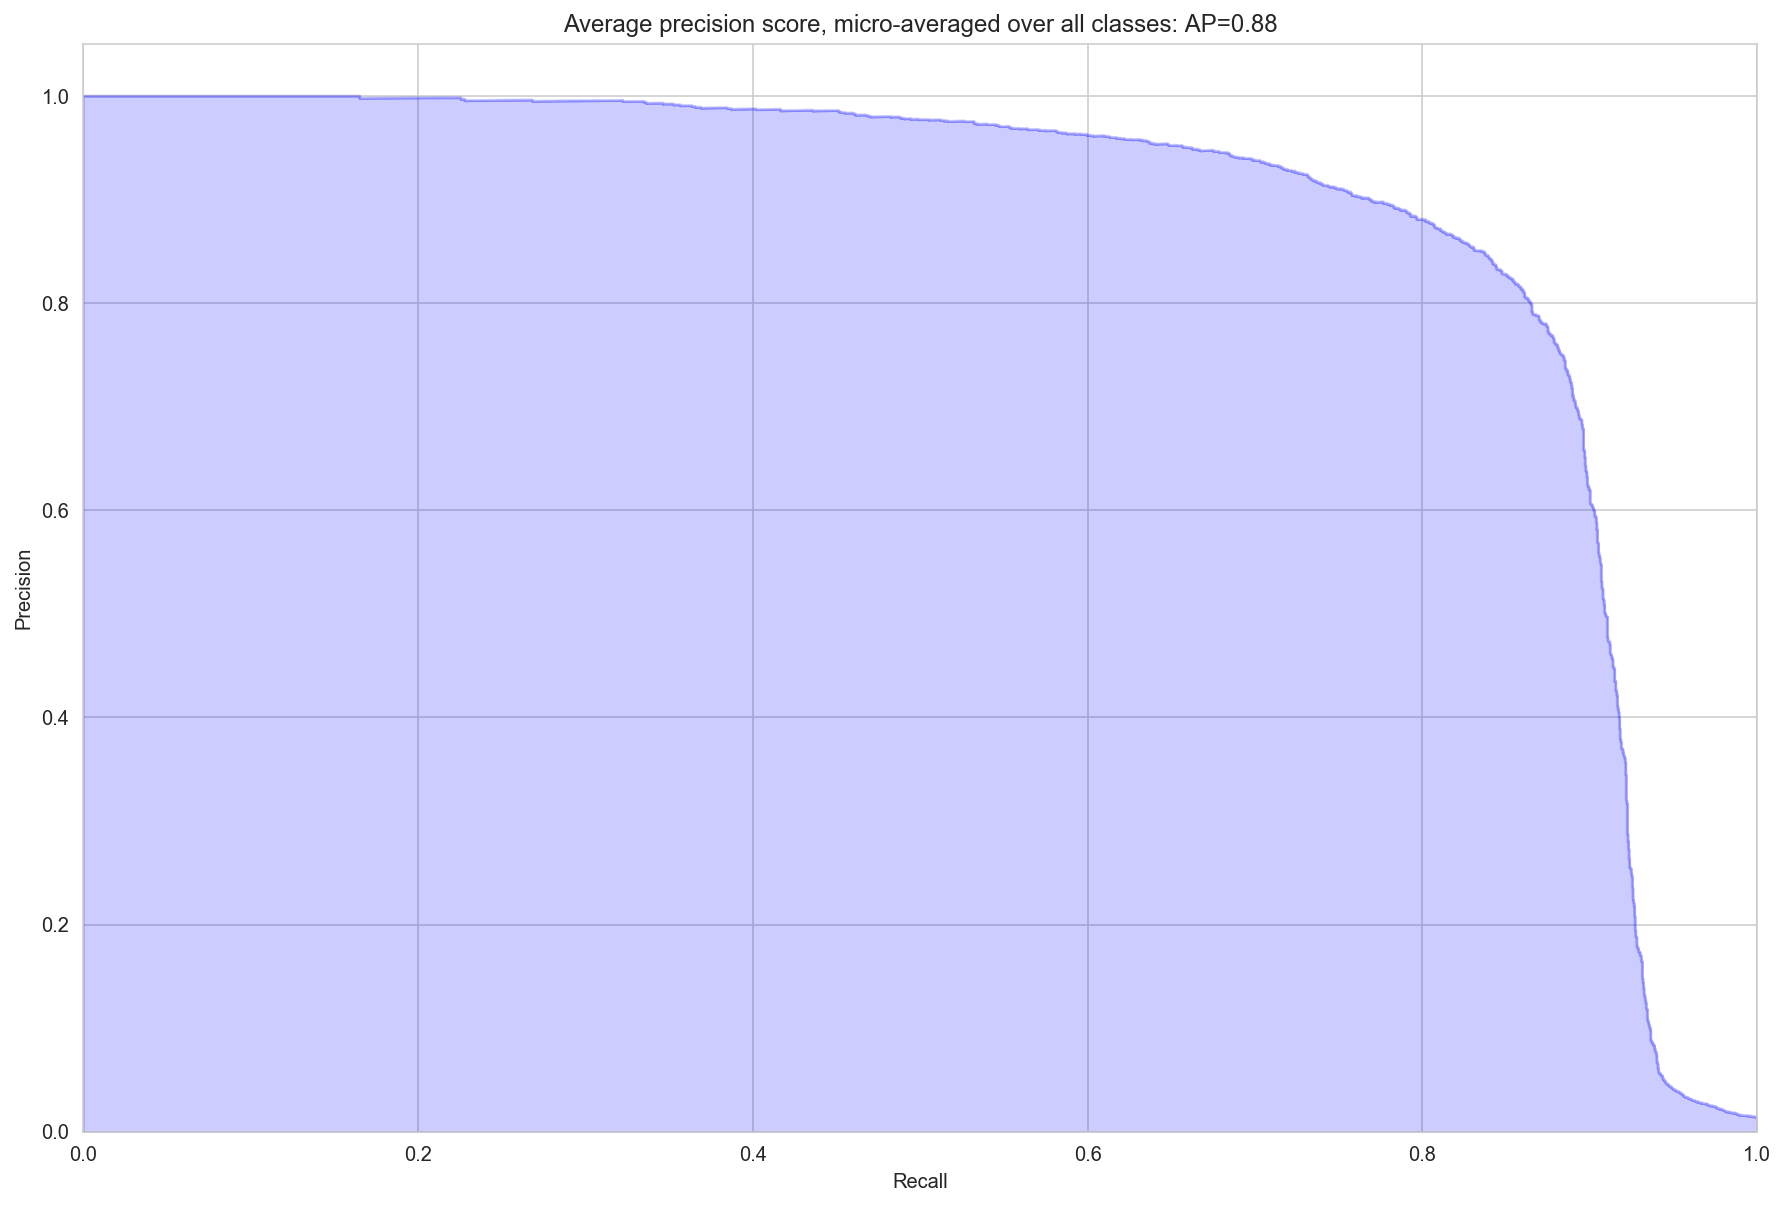

In [20]:
plt.figure(figsize=(15, 10))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

## Confusion Matrix for top 10 categories

In [21]:
import itertools

from sklearn.metrics import confusion_matrix

## Filter all docs belonging to one of the top 10 categories

In [22]:
indices = []
top_ten_set = set(top_ten_ids)
for idx, label in enumerate(df.label.values):
    if label in top_ten_set:
        indices.append(idx)

In [23]:
df_train = df.iloc[indices].query("modapte == 'train'")
df_test = df.iloc[indices].query("modapte == 'test'")
y_train = df_train.label.values
y_test = df_test.label.values

In [24]:
pipeline = Pipeline(
    memory=str(cache_dir),
    steps=[
        ("union", FeatureUnion(n_jobs=1, transformer_list=[
            ("title_stats", Pipeline([
                ("column", ColumnSelector("title")),
                ("stats", TextStats()),
                ("scaled", StandardScaler()),
            ])),
            ("body_stats", Pipeline([
                ("column", ColumnSelector("body")),
                ("stats", TextStats()),
                ("scaled", StandardScaler()),
            ])),
            ("combined_text", Pipeline([
                ("column", TextFromColumns2()),
                ("tfidf", TfidfVectorizer()),
            ])),
        ])),
        ("clf", LinearSVC(C=1)),
])

In [25]:
%%time
pipeline.fit(df_train, y_train)
y_pred = pipeline.predict(df_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

/Users/jochen/miniconda3/envs/ds_tutorial/lib/python3.6/site-packages/sklearn/pipeline.py:230: UserWarning: Persisting input arguments took 2.41s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/Users/jochen/miniconda3/envs/ds_tutorial/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

        earn      0.984     0.989     0.986      1087
         acq      0.960     0.982     0.971       710
    money-fx      0.803     0.814     0.808       145
       grain      0.759     0.524     0.620        42
       crude      0.858     0.884     0.871       164
       trade      0.835     0.927     0.878       109
    interest      0.845     0.744     0.791       117
        ship      0.817     0.690     0.748        71
       wheat      0.808     0.764     0.785        55
        corn      0.689     0.689     0.689        45

   micro avg      0.930     0.930     0.930      2545
   macro avg      0.836     0.801     0.815      2545
weighted avg      0.928     0.930     0.928      2545

CPU times: user 9.99 s, sys: 168 ms, total: 10.2 s
Wall time: 9.37 s


In [79]:
y_pred = pipeline.predict(df_test)
cm = confusion_matrix(y_test, y_pred)

In [80]:
top_ten_lookup = {tid: ttn for tid, ttn in zip(top_ten_ids, top_ten_names)}
xtick_names = [top_ten_lookup[tid] for tid in set(y_test)]

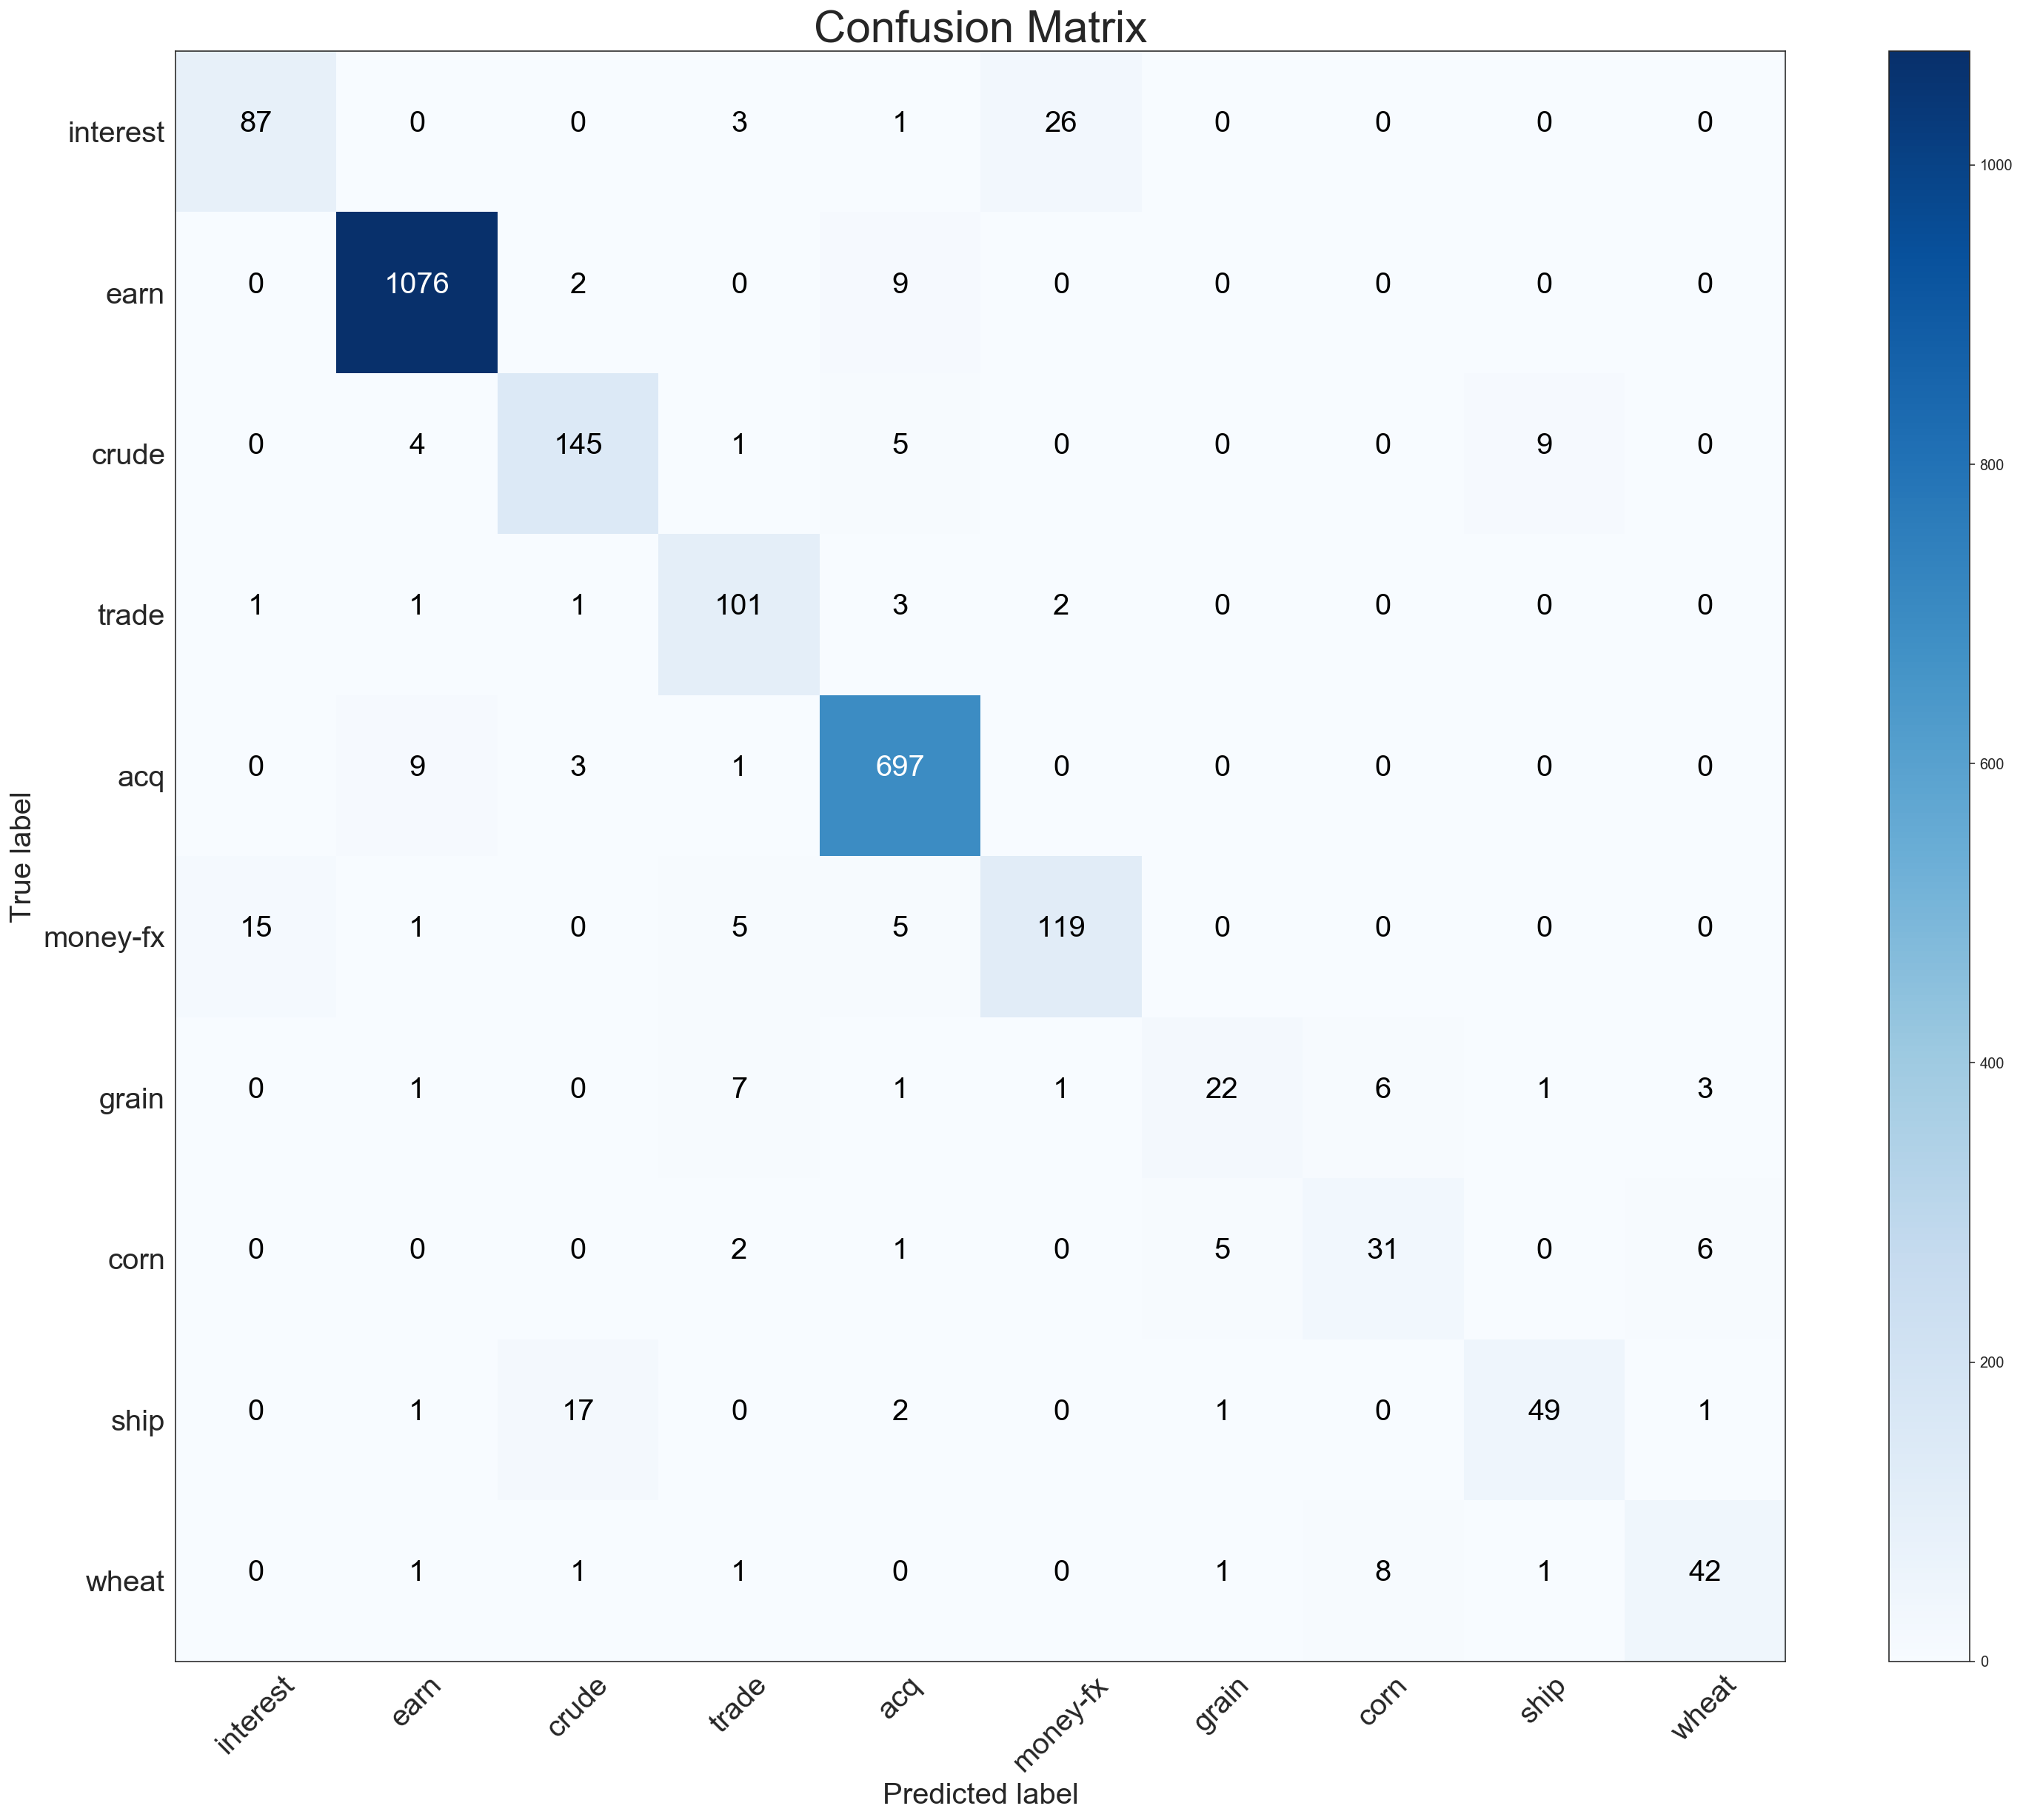

In [91]:
sns.set_style("white")
fig = plt.figure(figsize=(25, 20))
plot = fig.add_subplot(111)

#plt.figure()
normalize = False
#np.set_printoptions(precision=2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
title = plt.title("Confusion Matrix")
title.set_fontsize(30)
plt.colorbar()

tick_marks = np.arange(len(xtick_names))
plt.xticks(tick_marks, xtick_names, rotation=45)
plt.yticks(tick_marks, xtick_names)
plot.tick_params(axis='both', which='major', labelsize=20)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    text = plt.text(
        j, i, format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    text.set_fontsize(20)

#plt.tight_layout()
ylabel = plt.ylabel('True label')
ylabel.set_fontsize(20)
xlabel = plt.xlabel('Predicted label')
xlabel.set_fontsize(20)